In [3]:
import pandas as pd

In [169]:
sql = """
SELECT
  hq_name,
  COUNT(DISTINCT organisation_code) AS branches,
  SUM(item_count) AS items,
  SUM(item_pay_oope_amt)/SUM(item_count) AS oope_per_item,
  MAX(item_pay_oope_amt/item_count) AS max_oope_per_item
FROM
  `ebmdatalab.dispensers.dispensing_with_metadata`
WHERE year_month = '201703'
GROUP BY
  hq_name
ORDER BY
  oope_per_item DESC
"""
df = pd.io.gbq.read_gbq(sql, 'ebmdatalab', dialect='standard')

In [170]:
df.head(10)

,hq_name,branches,items,oope_per_item,max_oope_per_item
0,ZAIMRA LTD,1,5196,2.091801,79.00
1,MEDICX A G LIMITED,1,5459,1.679353,73.68
2,MEDI-CALL HEALTHCARE LTD,1,2032,1.438484,79.00
3,JM PATEL LTD,1,9196,1.270876,79.00
4,C.K & SONS PHARMACY,1,5221,0.781268,79.00
5,MERITPLAN LTD,2,8713,0.720877,99.00
6,BESPOKE PHARMACY LTD,3,55939,0.340218,86.99
7,OJELACEUTICALS LIMITED,1,3537,0.303200,36.98
8,MR ANIL KUMAR SHARMA,1,5811,0.293103,86.99
9,SPRING PHARMACY,1,8877,0.279374,50.00


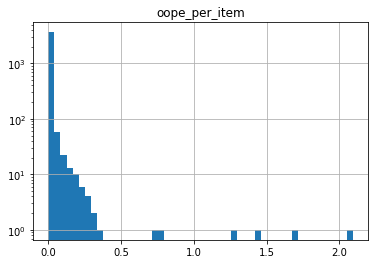

In [58]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
df.hist(ax=ax, column=['oope_per_item'], bins=50)
ax.set_yscale('log')

In [20]:
print("The median OOPE is %s" % df.oope_per_item.median())

The median OOPE is 0.0


In [48]:
print ("The worst 10 HQs account for %s items" % df['items'].head(10).sum())
print("About the same (%s) as the best 7" % df['items'].tail(7).sum())

The worst 10 HQs account for 109981 items
About the same (100681) as the best 7


## How does high OOPE covary with group size?

None of the large multiples has high mean OOPEs:

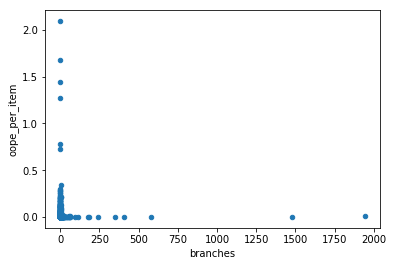

In [172]:
df.plot.scatter(x='branches', y='oope_per_item')

# Investigate worst and best 10ish

In [29]:
sql = """
SELECT
  item_pay_dr_nic,
  item_count,
  item_pay_oope_amt,
  bnf_code,
  bnf_name,
  name,
  postcode
FROM
  `ebmdatalab.dispensers.dispensing_with_metadata`
WHERE year_month = '201703' AND 
(%s)
"""
hq_names = []
for name in list(df.hq_name.head(10)):
    hq_names.append("hq_name = '%s'" % name)
baddies = pd.io.gbq.read_gbq(sql % " OR ".join(hq_names), 'ebmdatalab', dialect='standard')

In [49]:
sql = """
SELECT
  item_pay_dr_nic,
  item_count,
  item_pay_oope_amt,
  bnf_code,
  bnf_name,
  name,
  postcode
FROM
  `ebmdatalab.dispensers.dispensing_with_metadata`
WHERE year_month = '201703' AND 
(%s)
"""
hq_names = []
for name in list(df.hq_name.tail(7)):
    hq_names.append("hq_name = '%s'" % name)
goodies = pd.io.gbq.read_gbq(sql % " OR ".join(hq_names), 'ebmdatalab', dialect='standard')

In [60]:
baddies.head(1)

,item_pay_dr_nic,item_count,item_pay_oope_amt,bnf_code,bnf_name,name,postcode
0,52.26,41,0.0,0204000H0AAAJAJ,Bisoprolol Fumar_Tab 2.5mg,SPRING PHARMACY LTD,N1 5LG


### The worst 10 HQs 
...are accounted for by 12 dispensers, with a mean item count of 9165, mean NIC of £66,000, and mean OOPE of £5770. 3.5% of prescription items come with OOPEs (compared with 0 for the best dispensers). In a single month they charged £69,000 in OOPE, equivalent to a 9% surcharge.

In [89]:
baddies.groupby("name").sum()

,item_pay_dr_nic,item_count,item_pay_oope_amt
name,,,
BIRKWOOD PHARMACY,106179.76,19749,10341.15
C K & SONS,33487.40,5221,4079.00
IMPERIUN PHARMACY,24575.03,3537,1072.42
MARISCO PHARMACY,158056.87,20486,6286.61
NEWMARKET PHARMACY,80359.16,15704,2403.70
RYANS LOCAL,22613.05,2032,2923.00
RYANS PHARMACY,49271.80,5196,10869.00
SPRING PHARMACY LTD,83883.55,8877,2480.00
ST STEPHENS CHEMIST,57625.77,8713,6281.00


### The best 7 HQs 
...are also accounted for by 12 dispensers, with a mean item count of 8390, mean NIC of £73,000, and mean OOPE of £0 (indeed, a maximum OOPE of £0)

In [61]:
goodies.head(1)

,item_pay_dr_nic,item_count,item_pay_oope_amt,bnf_code,bnf_name,name,postcode
0,42.65,30,0.0,0303020G0AAABAB,Montelukast_Tab 10mg,ACKERS CHEMISTS,DA10 0HF


In [91]:
goodies.groupby("name").sum()

,item_pay_dr_nic,item_count,item_pay_oope_amt
name,,,
ACKERS CHEMISTS,65734.79,9046,0.0
BUCHAN'S CHEMIST,24358.48,2058,0.0
CHARTER PHARMACY,107160.09,10277,0.0
EXPERTCARE LIMITED,48846.48,6650,0.0
GREEN LANE PHARMACY,99592.53,11932,0.0
HAYFIELD PHARMACY,24739.67,3161,0.0
KITSONS PHARMACEUTICAL CHEMIST,56164.80,5990,0.0
LANE AND STEDMAN,43822.54,5777,0.0
ND CHEMISTS LTD,126847.60,14035,0.0


## Do the best and worst dispense very different things?

No, they look quite similar, although things that were not dispensed at all in the "good" dispensaries appear to have higher per-item OOPE.

There are 4836 presentations represented, of which 1090 only appear in the "good" dispensers, and 1098 in the "bad", leaving 2648 in both.  Descriptive statistics for the "bad" and "good" groups are very similar.

The mean OOPE per item in the "bad" group was 11p. For presentations not actually dispensed in the "good" group, the mean OOPE per item was 18p; presentations also dispensed in the "good" group had a mean OOPE per item of 8p.


In [99]:
df3 = baddies.groupby('bnf_name').sum()
df3['oope_per_item'] = df3['item_pay_oope_amt'] / df3['item_pay_dr_nic']
baddy_presentations = df3.sort_values('oope_per_item', ascending=False)
baddy_presentations.describe()

,item_pay_dr_nic,item_count,item_pay_oope_amt,oope_per_item
count,3746.000000,3746.000000,3746.000000,3746.000000
mean,211.380873,29.359584,18.498043,0.110807
std,661.259708,129.591249,141.991871,0.736218
min,0.200000,1.000000,0.000000,0.000000
25%,15.930000,1.000000,0.000000,0.000000
50%,49.000000,3.000000,0.000000,0.000000
75%,162.500000,12.000000,0.000000,0.000000
max,14092.550000,2955.000000,3402.160000,15.280992


In [96]:
df3 = goodies.groupby('bnf_name').sum()
df3['oope_per_item'] = df3['item_pay_oope_amt'] / df3['item_pay_dr_nic']
goody_presentations = df3.sort_values('oope_per_item', ascending=False)
goody_presentations.describe()

,item_pay_dr_nic,item_count,item_pay_oope_amt,oope_per_item
count,3738.000000,3738.000000,3738.0,3738.0
mean,234.336910,26.934457,0.0,0.0
std,676.611321,107.973680,0.0,0.0
min,0.340000,1.000000,0.0,0.0
25%,17.707500,1.000000,0.0,0.0
50%,54.865000,3.000000,0.0,0.0
75%,184.890000,13.000000,0.0,0.0
max,13278.600000,2012.000000,0.0,0.0


In [128]:
# Now compare these
#baddy_presentations = df3[(df3['oope_per_item'] > 0) & (df3['item_count'] > 10)]
compared = baddy_presentations.merge(
    goody_presentations,
    left_index=True,
    right_index=True,
    suffixes=["_bad", "_good"],
    how="outer"
)
compared.sort_values("oope_per_item_bad", ascending=False)

,item_pay_dr_nic_bad,item_count_bad,item_pay_oope_amt_bad,oope_per_item_bad,item_pay_dr_nic_good,item_count_good,item_pay_oope_amt_good,oope_per_item_good
bnf_name,,,,,,,,
Orgran_G/F W/F Rice & Millet Spiral,2.42,1.0,36.98,15.280992,NaN,NaN,NaN,NaN
Glutafin_G/F W/F Mini Cracker,2.96,1.0,36.98,12.493243,5.92,1.0,0.0,0.0
Isotard 25 XL_Tab 25mg,6.75,1.0,79.00,11.703704,40.50,2.0,0.0,0.0
Glutafin_G/F W/F Crisp Bread,3.25,1.0,36.98,11.378462,13.00,3.0,0.0,0.0
Solgar_Vit D3 Cap 400u,3.71,1.0,40.00,10.781671,NaN,NaN,NaN,NaN
Bio-Vitamin D3_Cap 1000u,61.52,29.0,635.00,10.321847,1.44,1.0,0.0,0.0
Dermacolor_Camouflage Creme,11.00,1.0,99.00,9.000000,NaN,NaN,NaN,NaN
Loprofin_L/P Fusilli,8.94,1.0,79.00,8.836689,NaN,NaN,NaN,NaN
Respond_OstoMart OstoMist Grapefruit P/Spy 50ml,8.34,1.0,73.68,8.834532,NaN,NaN,NaN,NaN


In [123]:
import numpy as np
good_only = compared[np.isnan(compared['item_count_bad'])]
bad_only = compared[np.isnan(compared['item_count_good'])]
both = compared[(~np.isnan(compared['item_count_good'])) & (~np.isnan(compared['item_count_bad']))]

In [114]:
good_only.describe()

,item_pay_dr_nic_bad,item_count_bad,item_pay_oope_amt_bad,oope_per_item_bad,item_pay_dr_nic_good,item_count_good,item_pay_oope_amt_good,oope_per_item_good
count,0.0,0.0,0.0,0.0,1090.000000,1090.000000,1090.0,1090.0
mean,NaN,NaN,NaN,NaN,83.941229,2.241284,0.0,0.0
std,NaN,NaN,NaN,NaN,198.828843,2.659001,0.0,0.0
min,NaN,NaN,NaN,NaN,0.340000,1.000000,0.0,0.0
25%,NaN,NaN,NaN,NaN,10.492500,1.000000,0.0,0.0
50%,NaN,NaN,NaN,NaN,28.475000,1.000000,0.0,0.0
75%,NaN,NaN,NaN,NaN,83.705000,2.000000,0.0,0.0
max,NaN,NaN,NaN,NaN,3933.700000,36.000000,0.0,0.0


In [115]:
bad_only.describe()

,item_pay_dr_nic_bad,item_count_bad,item_pay_oope_amt_bad,oope_per_item_bad,item_pay_dr_nic_good,item_count_good,item_pay_oope_amt_good,oope_per_item_good
count,1098.000000,1098.000000,1098.000000,1098.000000,0.0,0.0,0.0,0.0
mean,93.676548,2.225865,11.366148,0.178251,NaN,NaN,NaN,NaN
std,361.657575,2.936581,59.513561,0.963518,NaN,NaN,NaN,NaN
min,0.200000,1.000000,0.000000,0.000000,NaN,NaN,NaN,NaN
25%,9.020000,1.000000,0.000000,0.000000,NaN,NaN,NaN,NaN
50%,26.670000,1.000000,0.000000,0.000000,NaN,NaN,NaN,NaN
75%,76.280000,2.000000,0.000000,0.000000,NaN,NaN,NaN,NaN
max,9084.450000,33.000000,1063.980000,15.280992,NaN,NaN,NaN,NaN


In [116]:
both.describe()

,item_pay_dr_nic_bad,item_count_bad,item_pay_oope_amt_bad,oope_per_item_bad,item_pay_dr_nic_good,item_count_good,item_pay_oope_amt_good,oope_per_item_good
count,2648.000000,2648.000000,2648.000000,2648.000000,2648.000000,2648.000000,2648.0,2648.0
mean,260.187273,40.610650,21.455302,0.082841,296.244498,37.098943,0.0,0.0
std,745.861776,152.723758,164.399634,0.615984,785.434767,126.892492,0.0,0.0
min,0.740000,1.000000,0.000000,0.000000,0.420000,1.000000,0.0,0.0
25%,21.235000,2.000000,0.000000,0.000000,23.480000,2.000000,0.0,0.0
50%,61.825000,6.000000,0.000000,0.000000,74.130000,6.000000,0.0,0.0
75%,216.192500,21.000000,0.000000,0.000000,244.755000,22.000000,0.0,0.0
max,14092.550000,2955.000000,3402.160000,12.493243,13278.600000,2012.000000,0.0,0.0
